# Classifying Urban sounds using Deep Learning

## 4 Model Refinement 

### Load Preprocessed data 

#### Model refinement

In our inital attempt, we were able to achieve a Classification Accuracy score of: 

* Training data Accuracy:  92.3% 
* Testing data Accuracy:  87% 

We will now see if we can improve upon that score using a Convolutional Neural Network (CNN). 

#### Feature Extraction refinement 

In the prevous feature extraction stage, the MFCC vectors would vary in size for the different audio files (depending on the samples duration). 

However, CNNs require a fixed size for all inputs. To overcome this we will zero pad the output vectors to make them all the same size. 

In [21]:
import pandas as pd
import os
import librosa
import numpy as np

# Set paths
fulldatasetpath = r'D:\DAUP\UrbanSound8K\audio'
metadata = pd.read_csv(r'D:\DAUP\UrbanSound8K\metadata\UrbanSound8K.csv')

print(f"Total files in metadata: {len(metadata)}")
print(f"Audio path: {fulldatasetpath}")


Total files in metadata: 8732
Audio path: D:\DAUP\UrbanSound8K\audio


In [6]:
# Check the metadata structure
print(metadata.head())
print("\nColumn names:")
print(metadata.columns.tolist())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

Column names:
['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class']


In [22]:
# Maximum padding length for MFCC features
max_pad_len = 174

def extract_features(file_name):
    """
    Extract MFCC features from audio file
    """
    try:
        # Load audio file (without res_type to avoid resampy dependency)
        audio, sample_rate = librosa.load(file_name, duration=4)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # Pad or truncate to fixed length
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            # Pad if shorter
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate if longer
            mfccs = mfccs[:, :max_pad_len]
        
        return mfccs
    
    except Exception as e:
        # Return None if feature extraction fails
        return None

# Initialize lists
features = []
success_count = 0
fail_count = 0

# Process all audio files
print("Starting feature extraction...\n")

for index, row in metadata.iterrows():
    # Build file path
    file_path = os.path.join(fulldatasetpath, f'fold{row["fold"]}', row['slice_file_name'])
    
    # Check if file exists
    if not os.path.exists(file_path):
        fail_count += 1
        continue
    
    # Extract features
    data = extract_features(file_path)
    
    if data is not None:
        features.append([data, row['class']])
        success_count += 1
        
        # Progress update every 500 files
        if success_count % 500 == 0:
            print(f"Processed {success_count} files successfully...")
    else:
        fail_count += 1

print(f"\n{'='*50}")
print(f"Feature extraction complete!")
print(f"Success: {success_count} files")
print(f"Failed: {fail_count} files")
print(f"{'='*50}\n")

# Convert to DataFrame
featuresdf = pd.DataFrame(features, columns=['feature', 'class_label'])
print(f"Features DataFrame shape: {featuresdf.shape}")


Starting feature extraction...

Processed 500 files successfully...
Processed 1000 files successfully...
Processed 1500 files successfully...
Processed 2000 files successfully...
Processed 2500 files successfully...
Processed 3000 files successfully...
Processed 3500 files successfully...


C:\Users\THARUN\AppData\Roaming\Python\Python313\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Processed 4000 files successfully...
Processed 4500 files successfully...
Processed 5000 files successfully...
Processed 5500 files successfully...
Processed 6000 files successfully...
Processed 6500 files successfully...
Processed 7000 files successfully...
Processed 7500 files successfully...
Processed 8000 files successfully...


C:\Users\THARUN\AppData\Roaming\Python\Python313\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
C:\Users\THARUN\AppData\Roaming\Python\Python313\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Processed 8500 files successfully...

Feature extraction complete!
Success: 8732 files
Failed: 0 files

Features DataFrame shape: (8732, 2)


In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

# Remove rows where feature extraction failed (None values)
featuresdf_clean = featuresdf[featuresdf.feature.notna()]
print(f"Original samples: {len(featuresdf)}")
print(f"Clean samples: {len(featuresdf_clean)}")

# Get max length of features for padding
max_len = max([len(x) for x in featuresdf_clean.feature])
print(f"Max feature length: {max_len}")

# Pad all features to the same length
def pad_features(features, max_len):
    padded = []
    for feature in features:
        if len(feature) < max_len:
            # Pad with zeros
            padded_feature = np.pad(feature, (0, max_len - len(feature)), mode='constant')
        else:
            # Truncate if longer
            padded_feature = feature[:max_len]
        padded.append(padded_feature)
    return np.array(padded)

# Apply padding
X = pad_features(featuresdf_clean.feature.tolist(), max_len)
y = np.array(featuresdf_clean.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

print(f"Feature shape: {X.shape}")
print(f"Label shape: {yy.shape}")
print(f"Number of classes: {yy.shape[1]}")


Original samples: 8732
Clean samples: 8732
Max feature length: 40
Feature shape: (8732, 40, 174)
Label shape: (8732, 10)
Number of classes: 10


In [24]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, yy, test_size=0.2, random_state=42, stratify=yy
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 6985
Testing samples: 1747


### Convolutional Neural Network (CNN) model architecture 


We will modify our model to be a Convolutional Neural Network (CNN) again using Keras and a Tensorflow backend. 

Again we will use a `sequential` model, starting with a simple model architecture, consisting of four `Conv2D` convolution layers, with our final output layer being a `dense` layer. 

The convolution layers are designed for feature detection. It works by sliding a filter window over the input and performing a matrix multiplication and storing the result in a feature map. This operation is known as a convolution. 


The `filter` parameter specifies the number of nodes in each layer. Each layer will increase in size from 16, 32, 64 to 128, while the `kernel_size` parameter specifies the size of the kernel window which in this case is 2 resulting in a 2x2 filter matrix. 

The first layer will receive the input shape of (40, 174, 1) where 40 is the number of MFCC's 174 is the number of frames taking padding into account and the 1 signifying that the audio is mono. 

The activation function we will be using for our convolutional layers is `ReLU` which is the same as our previous model. We will use a smaller `Dropout` value of 20% on our convolutional layers. 

Each convolutional layer has an associated pooling layer of `MaxPooling2D` type with the final convolutional layer having a `GlobalAveragePooling2D` type. The pooling layer is do reduce the dimensionality of the model (by reducing the parameters and subsquent computation requirements) which serves to shorten the training time and reduce overfitting. The Max Pooling type takes the maximum size for each window and the Global Average Pooling type takes the average which is suitable for feeding into our `dense` output layer.  

Our output layer will have 10 nodes (num_labels) which matches the number of possible classifications. The activation is for our output layer is `softmax`. Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which option has the highest probability.

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model parameters
num_rows = 40
num_columns = 174
num_channels = 1
num_classes = 10

# Build CNN model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(num_rows, num_columns, num_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Print model summary
print(model.summary())
print(f"\nTotal parameters: {model.count_params():,}")


C:\Users\THARUN\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 172, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 84, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 40, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 40, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 20, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,966,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,063,498 (7.87 MB)

 Trainable params: 2,062,538 (7.87 MB)

 Non-trainable params: 960 (3.75 KB)

None

Total parameters: 2,063,498


 ### Training 

Here we will train the model. As training a CNN can take a sigificant amount of time, we will start with a low number of epochs and a low batch size. If we can see from the output that the model is converging, we will increase both numbers.  

In [29]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks for better training
callbacks = [
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001),
    
    # Save best model
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Train the model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")


Starting training...
Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 221ms/step - accuracy: 0.4868 - loss: 1.5759 - val_accuracy: 0.3336 - val_loss: 2.4632 - learning_rate: 0.0010
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - accuracy: 0.6736 - loss: 0.9675 - val_accuracy: 0.5540 - val_loss: 2.2306 - learning_rate: 0.0010
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.7593 - loss: 0.7219 - val_accuracy: 0.6006 - val_loss: 1.7173 - learning_rate: 0.0010
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - accuracy: 0.8085 - loss: 0.5760 - val_accuracy: 0.7065 - val_loss: 4.1250 - learning_rate: 0.0010
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - accuracy: 0.8339 - loss: 0.4784 - val_accuracy: 0.6986 - val_loss: 2.7354 - learning_rate: 0.0010
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - accuracy: 0.8576 - loss: 0.4177 - val_accuracy: 0.5770 - val_loss: 3.3912 - learning_rate: 0.0010
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms

#**Evaluate the Model**

Test Accuracy: 90.33%
Test Loss: 0.3345
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.90      0.96      0.93       200
        car_horn       0.96      0.90      0.93        86
children_playing       0.86      0.81      0.83       200
        dog_bark       0.89      0.88      0.88       200
        drilling       0.94      0.93      0.93       200
   engine_idling       0.90      0.94      0.92       200
        gun_shot       0.94      0.97      0.95        75
      jackhammer       0.89      0.97      0.93       200
           siren       0.98      0.94      0.96       186
    street_music       0.84      0.80      0.82       200

        accuracy                           0.90      1747
       macro avg       0.91      0.91      0.91      1747
    weighted avg       0.90      0.90      0.90      1747



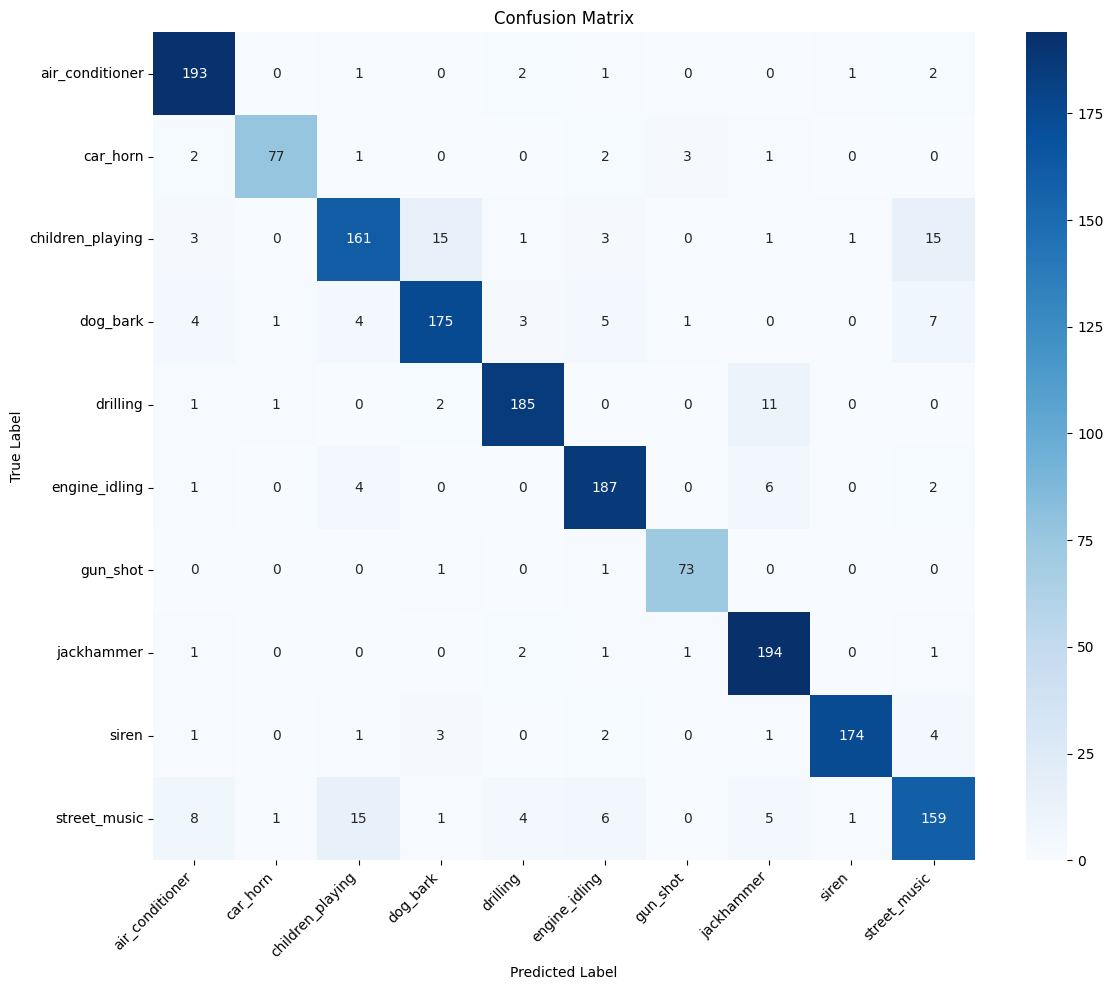

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Plot Training History**

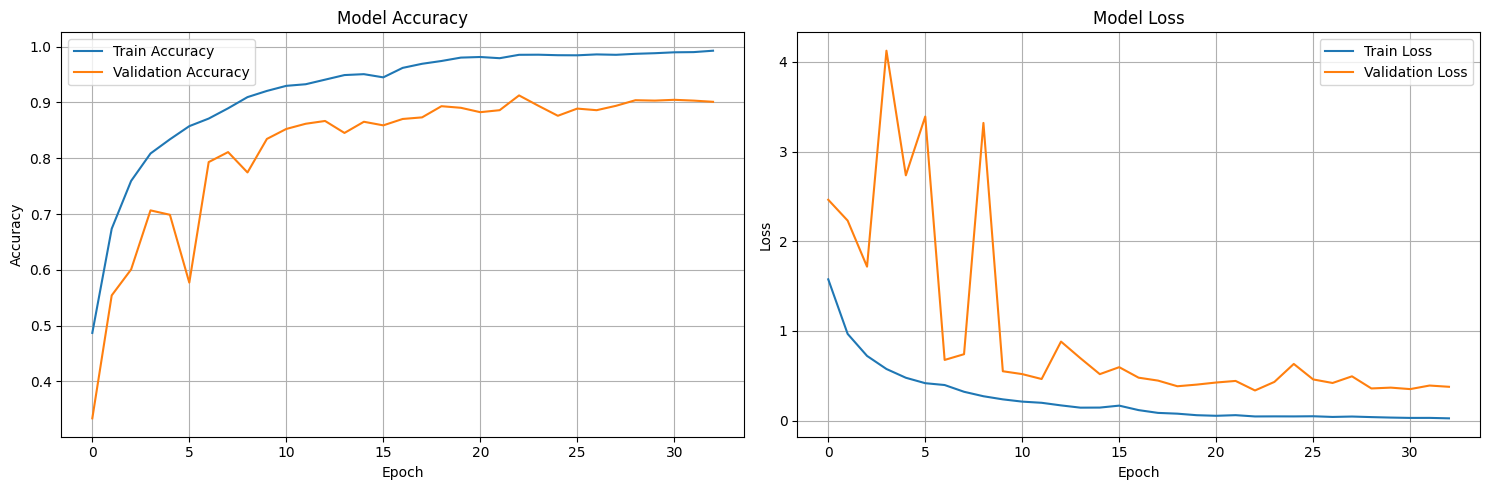

In [32]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [33]:
import random

# Test on random samples
num_samples = 5
random_indices = random.sample(range(len(X_test)), num_samples)

print("Testing on Random Samples:")
print("="*70)

for idx in random_indices:
    sample = X_test[idx:idx+1]
    true_label = le.classes_[y_test_classes[idx]]
    
    prediction = model.predict(sample, verbose=0)
    predicted_label = le.classes_[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    result = "✓" if true_label == predicted_label else "✗"
    print(f"{result} True: {true_label:20s} | Predicted: {predicted_label:20s} | Confidence: {confidence:.2f}%")


Testing on Random Samples:
✓ True: jackhammer           | Predicted: jackhammer           | Confidence: 99.92%
✗ True: street_music         | Predicted: children_playing     | Confidence: 83.01%
✓ True: jackhammer           | Predicted: jackhammer           | Confidence: 97.78%
✓ True: street_music         | Predicted: street_music         | Confidence: 99.94%
✗ True: jackhammer           | Predicted: drilling             | Confidence: 54.66%


In [34]:
# Add a final cell to save important files
import pickle

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save feature extraction parameters
params = {
    'max_pad_len': 174,
    'n_mfcc': 40,
    'sample_rate': 22050
}

with open('feature_params.pkl', 'wb') as f:
    pickle.dump(params, f)

print("Model and parameters saved successfully!")
print(f"- best_model.keras")
print(f"- label_encoder.pkl")
print(f"- feature_params.pkl")


Model and parameters saved successfully!
- best_model.keras
- label_encoder.pkl
- feature_params.pkl


In [35]:
def predict_sound(audio_file_path):
    """
    Predict the class of a new audio file
    """
    # Extract features
    audio, sample_rate = librosa.load(audio_file_path, duration=4)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # Pad to correct length
    pad_width = 174 - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :174]
    
    # Reshape for model input
    mfccs = mfccs.reshape(1, 40, 174, 1)
    
    # Predict
    prediction = model.predict(mfccs, verbose=0)
    predicted_class = le.classes_[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    return predicted_class, confidence

# Example usage:
# predicted_class, confidence = predict_sound('path/to/new/audio.wav')
# print(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)")


### Predictions  

Here we will modify our previous method for testing the models predictions on a specified audio .wav file. 

### Detailed Prediction on All Test Samples

In [37]:
import pandas as pd
import numpy as np

# Make predictions on all test samples
print("Predicting on all test samples...\n")
y_pred = model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Create a detailed results DataFrame
results = []

for i in range(len(X_test)):
    true_class = le.classes_[y_test_classes[i]]
    predicted_class = le.classes_[y_pred_classes[i]]
    confidence = np.max(y_pred[i]) * 100
    correct = "✓" if true_class == predicted_class else "✗"
    
    results.append({
        'Sample_ID': i + 1,
        'True_Label': true_class,
        'Predicted_Label': predicted_class,
        'Confidence_%': round(confidence, 2),
        'Correct': correct
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display summary
print("\n" + "="*80)
print("PREDICTION RESULTS SUMMARY")
print("="*80)
print(f"Total Test Samples: {len(results_df)}")
print(f"Correct Predictions: {(results_df['Correct'] == '✓').sum()}")
print(f"Wrong Predictions: {(results_df['Correct'] == '✗').sum()}")
print(f"Accuracy: {(results_df['Correct'] == '✓').sum() / len(results_df) * 100:.2f}%")
print(f"Average Confidence: {results_df['Confidence_%'].mean():.2f}%")
print("="*80)

# Display first 20 predictions
print("\nFirst 20 Predictions:")
print(results_df.head(20).to_string(index=False))

# Save to CSV
results_df.to_csv('prediction_results.csv', index=False)
print("\n✓ Full results saved to 'prediction_results.csv'")


Predicting on all test samples...

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step

PREDICTION RESULTS SUMMARY
Total Test Samples: 1747
Correct Predictions: 1578
Wrong Predictions: 169
Accuracy: 90.33%
Average Confidence: 94.64%

First 20 Predictions:
 Sample_ID       True_Label  Predicted_Label  Confidence_% Correct
         1  air_conditioner  air_conditioner     99.900002       ✓
         2     street_music     street_music     64.519997       ✓
         3         dog_bark         dog_bark     99.930000       ✓
         4  air_conditioner  air_conditioner    100.000000       ✓
         5         dog_bark         dog_bark    100.000000       ✓
         6         car_horn         car_horn     99.900002       ✓
         7         dog_bark         dog_bark    100.000000       ✓
         8         drilling         drilling     99.989998       ✓
         9  air_conditioner children_playing     57.619999       ✗
        10         car_horn         car_horn     95.080002       ✓
        11    engin

#### Observations 

The performance of our final model is very good and has generalised well, seeming to predict well when tested against new audio data. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import librosa
import os
import pandas as pd

print("="*80)
print("VALIDATING MODEL WITH SAMPLE AUDIO FILES")
print("="*80)

def predict_sample_audio(filepath, true_label):
    """
    Predict the class of an audio file with proper feature extraction
    """
    try:
        # Load audio file with fixed duration
        audio, sample_rate = librosa.load(filepath, duration=4, sr=22050)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # Ensure correct shape (40, 174)
        if mfccs.shape[1] < 174:
            # Pad if shorter
            pad_width = 174 - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate if longer
            mfccs = mfccs[:, :174]
        
        # Reshape for model input: (1, 40, 174, 1)
        mfccs_input = mfccs.reshape(1, 40, 174, 1)
        
        # Predict
        prediction = model.predict(mfccs_input, verbose=0)
        predicted_class = le.classes_[np.argmax(prediction[0])]
        confidence = np.max(prediction[0]) * 100
        
        # Get top 3 predictions
        top3_idx = np.argsort(prediction[0])[-3:][::-1]
        top3_classes = [le.classes_[i] for i in top3_idx]
        top3_probs = [prediction[0][i] * 100 for i in top3_idx]
        
        return {
            'file': os.path.basename(filepath),
            'true': true_label,
            'predicted': predicted_class,
            'confidence': confidence,
            'correct': true_label == predicted_class,
            'top3': list(zip(top3_classes, top3_probs))
        }
        
    except Exception as e:
        return None

# Get sample files from dataset (one from each class)
validation_results = []
tested_classes = set()

print("\nTesting sample audio files...\n")

for index, row in metadata.iterrows():
    class_name = row['class']
    
    # Test only one sample per class
    if class_name in tested_classes:
        continue
    
    # Build file path
    filepath = os.path.join(
        r'D:/DAUP/UrbanSound8K/audio',
        f'fold{row["fold"]}',
        row['slice_file_name']
    )
    
    if not os.path.exists(filepath):
        continue
    
    # Predict
    result = predict_sample_audio(filepath, class_name)
    
    if result:
        validation_results.append(result)
        tested_classes.add(class_name)
        
        # Print result
        status = "✓" if result['correct'] else "✗"
        print(f"{status} Class: {class_name:20s}")
        print(f"   File: {result['file']}")
        print(f"   Predicted: {result['predicted']:20s} ({result['confidence']:.2f}%)")
        print(f"   Top 3 predictions:")
        for pred_class, prob in result['top3']:
            print(f"      - {pred_class:20s}: {prob:.2f}%")
        print()
    
    # Stop after testing all 10 classes
    if len(tested_classes) == 10:
        break

# Summary
if len(validation_results) > 0:
    correct = sum(1 for r in validation_results if r['correct'])
    total = len(validation_results)
    
    print("="*80)
    print("VALIDATION SUMMARY")
    print("="*80)
    print(f"Total Samples Tested: {total}")
    print(f"Correct Predictions: {correct}")
    print(f"Wrong Predictions: {total - correct}")
    print(f"Validation Accuracy: {(correct/total)*100:.2f}%")
    print("="*80)
    
    # Create detailed results table
    validation_df = pd.DataFrame([{
        'File': r['file'],
        'True_Label': r['true'],
        'Predicted_Label': r['predicted'],
        'Confidence_%': round(r['confidence'], 2),
        'Correct': '✓' if r['correct'] else '✗'
    } for r in validation_results])
    
    print("\nDetailed Results:")
    print(validation_df.to_string(index=False))
    
    # Save results
    validation_df.to_csv('sample_validation_results.csv', index=False)
    print("\n✓ Sample validation results saved to 'sample_validation_results.csv'")
    
    # Show which classes were correct/wrong
    print("\nPer-Class Results:")
    for r in validation_results:
        status_icon = "✓" if r['correct'] else "✗"
        print(f"{status_icon} {r['true']:20s} → {r['predicted']:20s} ({r['confidence']:.1f}%)")
        
else:
    print("⚠ No samples could be processed. Check file paths.")


VALIDATING MODEL WITH SAMPLE AUDIO FILES

Testing sample audio files...



KeyboardInterrupt: 

In [ ]:
# Class: Air Conditioner

filename = '../UrbanSound Dataset sample/audio/100852-0-0-0.wav' 
print_prediction(filename) 

C:\Users\THARUN\AppData\Local\Temp\ipykernel_14444\1276609321.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_name, duration=4)
C:\Users\THARUN\AppData\Roaming\Python\Python313\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


AttributeError: 'NoneType' object has no attribute 'reshape'

In [ ]:
# Class: Drilling

filename = '../UrbanSound Dataset sample/audio/103199-4-0-0.wav'
print_prediction(filename) 

The predicted class is: drilling 

air_conditioner 		 :  0.00000013431598233637487282976508
car_horn 		 :  0.00000025490251687187992502003908
children_playing 		 :  0.00001615423752809874713420867920
dog_bark 		 :  0.00000021904463665123330429196358
drilling 		 :  0.99468487501144409179687500000000
engine_idling 		 :  0.00000016201553876271646004170179
gun_shot 		 :  0.00000000003519966262910401155750
jackhammer 		 :  0.00004046132744406349956989288330
siren 		 :  0.00000000724200077684145071543753
street_music 		 :  0.00525784213095903396606445312500
